In [1]:
import pandas as pd     # Se carga la Libreria de pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
sns.set(style="darkgrid")
sns.set(font_scale=0.9)
pd.options.mode.copy_on_write = True
import requests

In [46]:
df_homicidios= pd.read_excel('data/homicidios.xlsx', sheet_name=None)

In [47]:
print(df_homicidios.keys())

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS', 'clas'])


In [48]:
df_hechos_homicidios= df_homicidios['HECHOS']           # Se carga el dataset de "Hechos de Homicidios"
df_victimas_homicidios= df_homicidios['VICTIMAS']       # Se carga el dataset de "Victimas de Homicidios"

In [5]:
# Se carga el mapa de Buenos Aires
url_caba = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson"
gdf_caba = gpd.read_file(url_caba)

#### `Analisis del dataSet "Hechos_Homicidios"`

In [49]:
df_hechos_homicidios.isna().sum()

ID                         0
N_VICTIMAS                 0
FECHA                      0
AAAA                       0
MM                         0
DD                         0
HORA                       0
HH                         0
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
dtype: int64

##### Se cuentas los valores nulos de las columnas y se puede ser que Altura tiene 567 datos nulos y Cruce tiene 171 datos nulos. Analizando los primeros registros del dataset, se puede ver que 'Cruce' tiene los mismos valores que las 'direccion normalizada' y 'lugar_del_hecho' por lo tanto se eliminara 'Cruce', 'direccion normalizada'. Las columnas altura y XY(CABA), Calle, AAAA, MM, DD no son relevantes para este analisis por lo tanto tambien se eliminaran.

In [50]:
# Eliminar columnas innecesarias
df_hechos_homicidios= df_hechos_homicidios.drop(['Dirección Normalizada', 'LUGAR_DEL_HECHO', 'HH','Altura', 
                                                 'Cruce', 'XY (CABA)', 'Calle','AAAA','MM', 'DD' ], axis=1) 

##### Se Cambian de nombres algunas columnas

In [51]:
df_hechos_homicidios = df_hechos_homicidios.rename(columns={'ID': 'Id_hecho', 'pos x': 'LONGITUD', 'pos y':'LATITUD'}) 

In [52]:
df_hechos_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id_hecho       696 non-null    object        
 1   N_VICTIMAS     696 non-null    int64         
 2   FECHA          696 non-null    datetime64[ns]
 3   HORA           696 non-null    object        
 4   TIPO_DE_CALLE  696 non-null    object        
 5   COMUNA         696 non-null    int64         
 6   LONGITUD       696 non-null    object        
 7   LATITUD        696 non-null    object        
 8   PARTICIPANTES  696 non-null    object        
 9   VICTIMA        696 non-null    object        
 10  ACUSADO        696 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 59.9+ KB


In [53]:
df_hechos_homicidios['LONGITUD'].value_counts() # Contar los valores

LONGITUD
.               12
-58.44451316     5
-58.50073810     4
-58.46743471     4
-58.50877521     4
                ..
-58.39100580     1
-58.37697717     1
-58.45807401     1
-58.42023854     1
-58.37976155     1
Name: count, Length: 605, dtype: int64

Haciendo un conteo de valores se puede observar que tiene 12 valores con "." por lo tanto procederemos a imputar estos datos y le pondremos 'SIN DATO'

In [54]:
df_hechos_homicidios.loc[df_hechos_homicidios['LONGITUD'] == '.','LONGITUD'] = 'SIN DATO'
df_hechos_homicidios.loc[df_hechos_homicidios['LATITUD'] == '.','LATITUD'] = 'SIN DATO'

In [12]:
df_hechos_homicidios.head()

,Id_hecho,N_VICTIMAS,FECHA,HORA,TIPO_DE_CALLE,COMUNA,LONGITUD,LATITUD,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,04:00:00,AVENIDA,8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,01:15:00,GRAL PAZ,9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,07:00:00,AVENIDA,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,00:00:00,AVENIDA,8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,05:20:00,AVENIDA,1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [55]:
# se verifica que no haya algun fecha con datos que no comiencen con el patron de año 20..
df_hechos_homicidios[~df_hechos_homicidios['FECHA'].astype(str).str.startswith('20')]      

,Id_hecho,N_VICTIMAS,FECHA,HORA,TIPO_DE_CALLE,COMUNA,LONGITUD,LATITUD,PARTICIPANTES,VICTIMA,ACUSADO


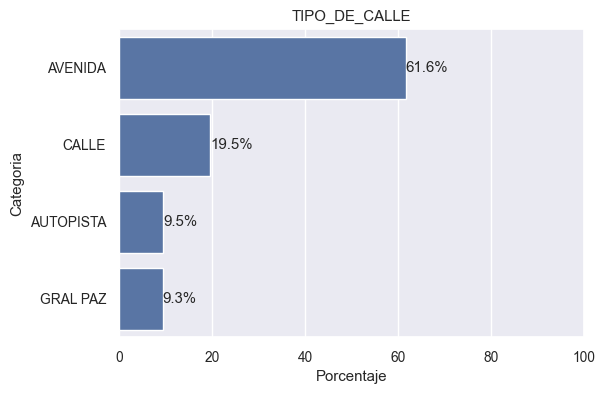

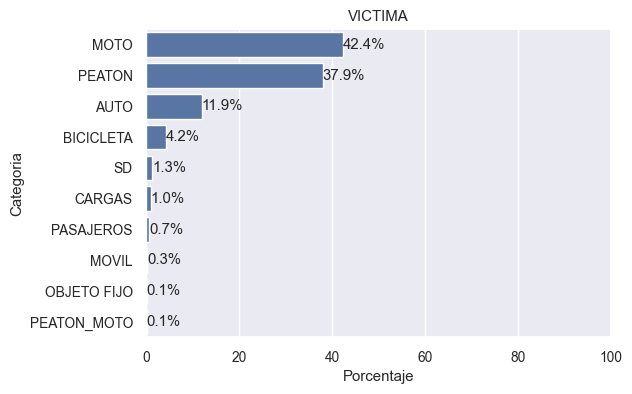

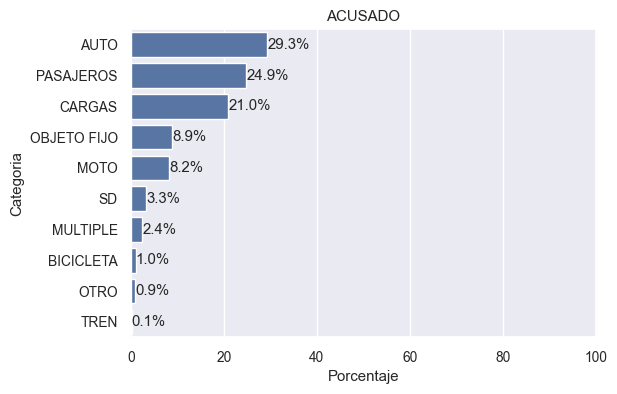

In [56]:
columnas= ['TIPO_DE_CALLE', 'VICTIMA', 'ACUSADO']
total_Homicidios= df_hechos_homicidios['Id_hecho'].count()

for col in columnas:    
    # Calcular porcentajes
    contador = df_hechos_homicidios[col].value_counts()
    porcentajes = (contador / total_Homicidios) * 100

    # Dibuja un grafico por cada Columna
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(y=porcentajes.index, x=porcentajes.values, orient='h')
    plt.ylabel('Categoria')
    plt.xlabel('Porcentaje')
    plt.title(col)
    
    #Dibuja los porcentajes en cada barra
    for i, valor in enumerate(porcentajes):
        plt.text(valor, i, f'{valor:.1f}%', ha='left', va='center')
    
    plt.xlim(0, 100)
    plt.show()

Observaciones:
- No hay valores que sean iguales pero que se diferencien por tener letras mayusculas o minusculas. Tambien se pueden ser valore con "SD" lo cual significa que no tiene datos de ese registro.
- El 61% de las muertes en accidentes o curren en Avenidas y el 19.5 en calles.
- El 42% (casi la mitad) de las victimas son personas que andan en moto y el 37% son peatones. Esto quiere decir que estan atropeyando muchas personas porque las victimas o los acusados no obedecen las señales de transito. Tambien puede ser que haga falta semaforos o pasarelas en estas vias para que las personas crucen las avenidas y calles
- El 29% de los acusados con autos particulares, el 24% son vehiculos de pasajeros y el 21% vehiculos de carga.
- Se puede observar que entre las victimas hay una Categoria "Objeto Fijo" no cual es ilogico, filtaremos por esta valor para ver como estan los demas datos de ese registro

In [57]:
df_hechos_homicidios[df_hechos_homicidios['VICTIMA'] == 'OBJETO FIJO']

,Id_hecho,N_VICTIMAS,FECHA,HORA,TIPO_DE_CALLE,COMUNA,LONGITUD,LATITUD,PARTICIPANTES,VICTIMA,ACUSADO
230,2017-0108,2,2017-09-02,04:53:08,GRAL PAZ,12,-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO


Se pude observar que fue un error ya que la victima es un objeto fijo y el acusado es un auto y logicamente deberia ser lo contrario. Se procedera a intercambiar estos datos

In [58]:
filtro = df_hechos_homicidios['VICTIMA'] == 'OBJETO FIJO'
df_hechos_homicidios.loc[filtro, ['VICTIMA', 'ACUSADO']] = df_hechos_homicidios.loc[filtro, ['ACUSADO', 'VICTIMA']].values

In [59]:
df_hechos_homicidios.loc[df_hechos_homicidios['ACUSADO'] == 'SD','ACUSADO'] = 'SIN DATO'
df_hechos_homicidios.loc[df_hechos_homicidios['VICTIMA'] == 'SD','VICTIMA'] = 'SIN DATO'

In [60]:
df_hechos_homicidios['PARTICIPANTES'] = df_hechos_homicidios['VICTIMA']+ ' - '+ df_hechos_homicidios['ACUSADO']

In [61]:
df_hechos_homicidios['COMUNA'].value_counts() # Contar los valores

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
0      2
Name: count, dtype: int64

##### Se puede ver que hay 2 registros con comuna "0" la cual no existe. Procederemos a imputarlos por la columna con mas victimas que es la "1"

In [62]:
df_hechos_homicidios.loc[df_hechos_homicidios['COMUNA'] == 0, 'COMUNA'] = 1

In [63]:
df_hechos_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id_hecho       696 non-null    object        
 1   N_VICTIMAS     696 non-null    int64         
 2   FECHA          696 non-null    datetime64[ns]
 3   HORA           696 non-null    object        
 4   TIPO_DE_CALLE  696 non-null    object        
 5   COMUNA         696 non-null    int64         
 6   LONGITUD       696 non-null    object        
 7   LATITUD        696 non-null    object        
 8   PARTICIPANTES  696 non-null    object        
 9   VICTIMA        696 non-null    object        
 10  ACUSADO        696 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 59.9+ KB


El dataset de victimas 696 registros y ningun valor nulo

In [64]:
df_hechos_homicidios[df_hechos_homicidios['HORA'] == 'SD']

,Id_hecho,N_VICTIMAS,FECHA,HORA,TIPO_DE_CALLE,COMUNA,LONGITUD,LATITUD,PARTICIPANTES,VICTIMA,ACUSADO
518,2019-0103,1,2019-12-18,SD,GRAL PAZ,11,-58.52169422,-34.59471640,MOTO - MOTO,MOTO,MOTO


In [65]:
df_hechos_homicidios.loc[df_hechos_homicidios['HORA'] == 'SD','HORA'] = '00:00:00'
df_hechos_homicidios['HORA']= pd.to_datetime(df_hechos_homicidios['HORA'], format='%H:%M:%S').dt.time

In [67]:
df_hechos_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id_hecho       696 non-null    object        
 1   N_VICTIMAS     696 non-null    int64         
 2   FECHA          696 non-null    datetime64[ns]
 3   HORA           696 non-null    object        
 4   TIPO_DE_CALLE  696 non-null    object        
 5   COMUNA         696 non-null    int64         
 6   LONGITUD       696 non-null    object        
 7   LATITUD        696 non-null    object        
 8   PARTICIPANTES  696 non-null    object        
 9   VICTIMA        696 non-null    object        
 10  ACUSADO        696 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 59.9+ KB


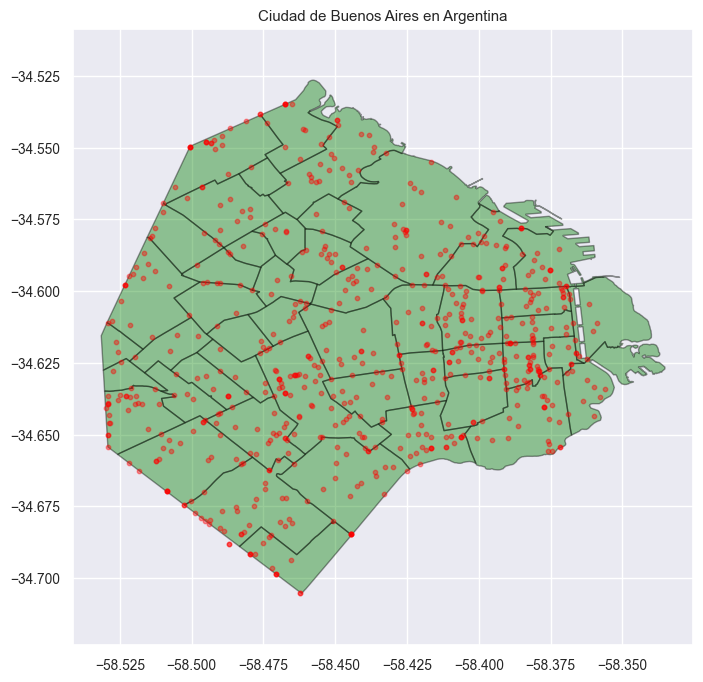

In [22]:
# Se cargan los Puntos geograficos
df_temp= df_hechos_homicidios[df_hechos_homicidios['LONGITUD'] != 'SIN DATO']
geometry = gpd.points_from_xy(df_temp['LONGITUD'], df_temp['LATITUD'], crs="EPSG:4326")
gdf_homicidios = gpd.GeoDataFrame(df_temp, geometry=geometry)

# Plotear el mapa de Argentina y la Ciudad Autónoma de Buenos Aires
fig, ax = plt.subplots(figsize=(8, 8))

gdf_caba.plot(ax=ax, color='green', edgecolor='black', alpha=0.4)
gdf_homicidios.plot(ax=ax, color='red', markersize=10, alpha=0.4)
ax.set_title('Ciudad de Buenos Aires en Argentina')
plt.axis('equal')
plt.show()

En este Grafico podemos observar la densidad de los homicidos segun los puntos geograficos donde ocurrieron. Se puede notar que hay algos sitios donde ocurrieron mas accidentes. Intentaremos everiguar porque en esas ubicaciones hay mas muerte por accidendes

#### `Analisis del dataSet "Victimas_Homicidios"`

In [68]:
df_victimas_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


- Se cambian de nombres las columnas "ID_hecho", y se elimina la columna 'FECHA_FALLECIMIENTO' que no es necesaria para este analisis
- Eliminamos las Columnas AAA, MM, DD y FECHA ya que estos datos estan en la tabla hechos y por lo tanto estan dedundando

In [69]:
df_victimas_homicidios= df_victimas_homicidios.rename(columns={'ID_hecho': 'Id_hecho'})
df_victimas_homicidios= df_victimas_homicidios.drop(['FECHA','AAAA', 'MM', 'DD', 'FECHA_FALLECIMIENTO' ], axis=1)

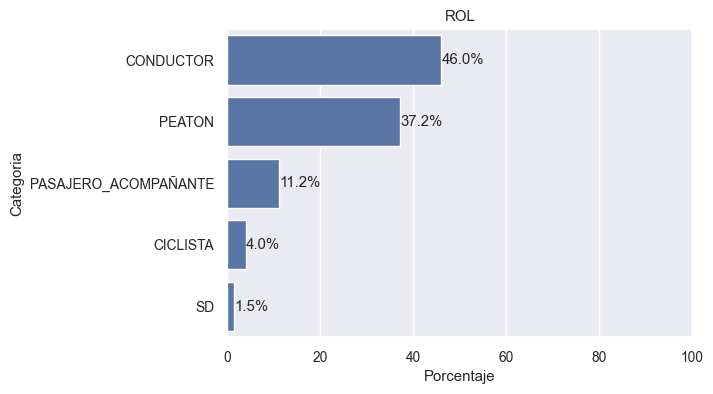

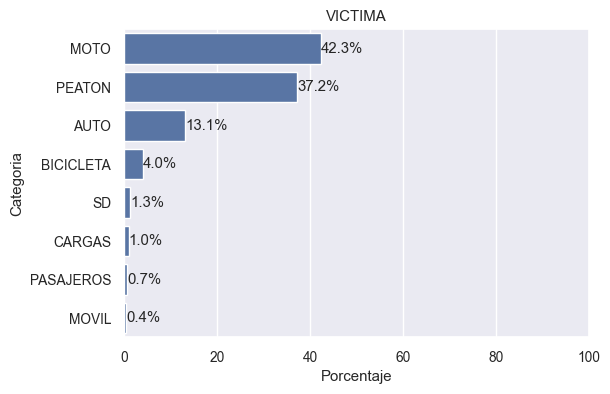

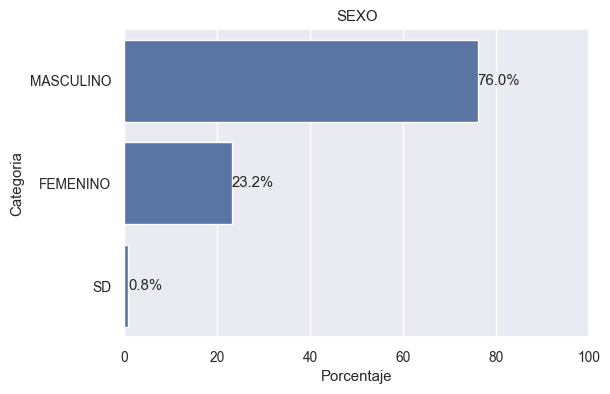

In [70]:
columnas= ['ROL', 'VICTIMA', 'SEXO']
total_Homicidios= df_victimas_homicidios['Id_hecho'].count()

for col in columnas:    
    # Calcular porcentajes
    contador = df_victimas_homicidios[col].value_counts()
    porcentajes = (contador / total_Homicidios) * 100

    # Dibuja un grafico por cada Columna
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(y=porcentajes.index, x=porcentajes.values, orient='h')
    plt.ylabel('Categoria')
    plt.xlabel('Porcentaje')
    plt.title(col)
    
    #Dibuja los porcentajes en cada barra
    for i, valor in enumerate(porcentajes):
        plt.text(valor, i, f'{valor:.1f}%', ha='left', va='center')
    
    plt.xlim(0, 100)
    plt.show()

##### Observaciones:
- No hay valores que sean iguales pero que se diferencien por tener letras mayusculas o minusculas. Se puede apreciar que tambien hay varios valores "SD" lo cual significa que no hay datos
- El 76% de las victimas son Masculinos

##### Se calculan nos promedios de las edades por sexo para imputar los registros faltantes

In [71]:
Promedio_edad_M= round(df_victimas_homicidios[(df_victimas_homicidios['SEXO'] == 'MASCULINO') & (df_victimas_homicidios['EDAD'] != 'SD')]['EDAD'].mean())
print(Promedio_edad_M)
Promedio_edad_F= round(df_victimas_homicidios[(df_victimas_homicidios['SEXO'] == 'FEMENINO') & (df_victimas_homicidios['EDAD'] != 'SD')]['EDAD'].mean())
print(Promedio_edad_F)

40
51


##### Se Imputan los los valores sin datos (SD) con el promedio de edad de cada sexo

In [72]:
df_victimas_homicidios.loc[(df_victimas_homicidios['SEXO'] == 'MASCULINO') & (df_victimas_homicidios['EDAD'] == 'SD'),'EDAD'] = Promedio_edad_M
df_victimas_homicidios.loc[(df_victimas_homicidios['SEXO'] == 'FEMENINO') & (df_victimas_homicidios['EDAD'] == 'SD'),'EDAD'] = Promedio_edad_F

##### Se Cambian los valores de las columnas que tienes "SD" por "SIN DATO". Tambien los valores de edad que quedan despues de la amputacion con "SD" se cambian a 0 y se transforma el tipo de dato de la columna

In [73]:
df_victimas_homicidios.loc[df_victimas_homicidios['ROL'] == 'SD','ROL'] = 'SIN DATO'
df_victimas_homicidios.loc[df_victimas_homicidios['VICTIMA'] == 'SD','VICTIMA'] = 'SIN DATO'
df_victimas_homicidios.loc[df_victimas_homicidios['SEXO'] == 'SD','SEXO'] = 'SIN DATO'
df_victimas_homicidios.loc[df_victimas_homicidios['EDAD'] == 'SD', 'EDAD'] = 0
df_victimas_homicidios['EDAD']= df_victimas_homicidios['EDAD'].astype(int)

In [74]:
df_victimas_homicidios.head()

,Id_hecho,ROL,VICTIMA,SEXO,EDAD
0,2016-0001,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,CONDUCTOR,MOTO,MASCULINO,29


In [75]:
rangos_etarios= {"De 1 a 10": [1,10], "De 11 a 17": [11,17], "De 18 a 25": [18,25], 
         "De 26 a 35": [26,35], "De 36 a 50": [36,50], "De 51 a 65": [51,65], "De 66 a 85": [66,85]}

In [76]:
lista_rangos= []
for index, fila in df_victimas_homicidios.iterrows():
    for clave, valor in rangos_etarios.items():
        if valor[0]<= fila['EDAD'] <= valor[1]:
            lista_rangos.append(clave)
            break
    if fila['EDAD'] == 0:
        lista_rangos.append('Sin Datos')
    if fila['EDAD'] > 85:
        lista_rangos.append('Mas de 85')
df_victimas_homicidios['RANGO ETARIO']=lista_rangos

In [77]:
df_victimas_homicidios

,Id_hecho,ROL,VICTIMA,SEXO,EDAD,RANGO ETARIO
0,2016-0001,CONDUCTOR,MOTO,MASCULINO,19,De 18 a 25
1,2016-0002,CONDUCTOR,AUTO,MASCULINO,70,De 66 a 85
2,2016-0003,CONDUCTOR,MOTO,MASCULINO,30,De 26 a 35
3,2016-0004,CONDUCTOR,MOTO,MASCULINO,18,De 18 a 25
4,2016-0005,CONDUCTOR,MOTO,MASCULINO,29,De 26 a 35
...,...,...,...,...,...,...
712,2021-0092,PEATON,PEATON,FEMENINO,50,De 36 a 50
713,2021-0093,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,18,De 18 a 25
714,2021-0094,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,43,De 36 a 50
715,2021-0095,CONDUCTOR,MOTO,MASCULINO,27,De 26 a 35


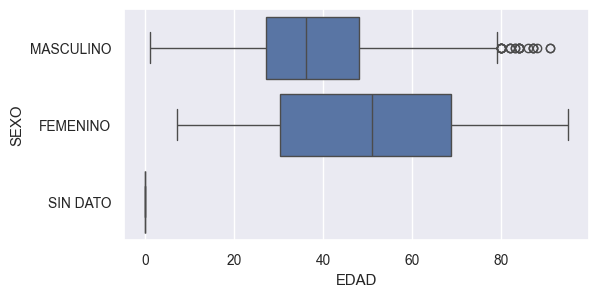

In [78]:
plt.figure(figsize= (6,3))
sns.boxplot(data=df_victimas_homicidios[df_victimas_homicidios['EDAD'] != 'SD'], x='EDAD', y='SEXO')
plt.show()

En este grafico podemos observar que la mediana de las victimas masculinos es mas o menos 37 y que la mayoria entan entre un pocos menos de 30 hasta los casi 80 años. En cambio las mediana de las victimas femeninas es un poco mas de 50 y las mayoria entan entre los 30 y los casi 100 años. Tambien se pueden ver alunos valores atipicos de edades entre los 80 y 90 años, pero no son outliers pues estan entre las edades normales que puede llegar a tener un ser humano

#### `Carga de Poblacion por Comuna`

Se descargó los datos de la poblacion por Comuna desde: https://censo.gob.ar/wp-content/uploads/2023/11/c2022_caba_est_c2_1.xlsx del censo del año 2022. Luego este se carga en un dataframe para limpiar los datos. No se abrio direcctamente desde el link porque da problemas de Cerfificado SSL

In [114]:
# Se cargan el excel con la cantidad de poblacion por comuna
df_poblacion= pd.read_excel('data/c2022_caba_est_c2_1.xlsx', sheet_name=None)

Se toman los las filas de 5 al 20 y la columna 1 hasta la 4 que es donde estan los datos que necesitamos. Despues se renombran las columnas

In [115]:
df_TotalHabitantes= df_poblacion['Cuadro 2.1'].iloc[5:20,1:]
df_TotalHabitantes.columns= ['COMUNA', 'SUPERFICIE_KM2', 'POBLACION', 'DENSIDAD_HAB/KM2']

In [116]:
# Se transforma el nombre de la clomuna por su numero del 1 al 15
df_TotalHabitantes['COMUNA']= range(1,16)
df_TotalHabitantes

,COMUNA,SUPERFICIE_KM2,POBLACION,DENSIDAD_HAB/KM2
5,1,17.9,223554,12489.1
6,2,6.3,161645,25657.9
7,3,6.4,196240,30662.5
8,4,22.7,229240,10098.7
9,5,6.7,194271,28995.7
10,6,6.9,203043,29426.5
11,7,12.4,215896,17411
12,8,22.5,204367,9083
13,9,16.6,169063,10184.5
14,10,12.6,173004,13730.5


#### `Exportacion de Datasets a .csv`

In [79]:
df_hechos_homicidios.to_csv('data/hechos_homicidios.csv', index=False)    #Exportar df_hechos_homicidios a un archivo hechos_homicidios.cvs
df_victimas_homicidios.to_csv('data/victimas_homicidios.csv', index=False)    #Exportar df_victimas_homicidios a un archivo victimas_homicidios.cvs

In [162]:
df_TotalHabitantes.to_csv('data/poblacion_BA.csv', index=False)    #Exportar df_victimas_homicidios a un archivo victimas_homicidios.cvs

################################################################################################################################

Obtener datos de la API "api-transporte.buenosaires.gob.ar"

In [4]:
url = 'https://apitransporte.buenosaires.gob.ar/transito/v1/semaforos?'
client_id = '01929d26b24941418358b80dd3ef7560'
client_secret = '8c1CcaDdEF0142B09AEaDD63D2a7068E'

parametros = {    
    'client_id': client_id,
    'client_secret': client_secret
}

In [5]:
respuesta = requests.get(url, params=parametros)

In [8]:
if respuesta.status_code == 200:
    datos = respuesta.json()['list']
df_semaforos= pd.DataFrame(datos)

In [21]:
df_semaforos= df_semaforos[~df_semaforos['latitude'].astype(str).str.startswith('0')]
df

,provider,type,code,name,status,latitude,longitude
0,UTC API,Cruce Citar,3337,3337,Conectado,-34.576578,-58.431704
1,UTC API,Cruce Citar,3338,3338,Conectado,-34.583724,-58.423080
2,UTC API,Cruce Citar,3339,3339,Conectado,-34.577002,-58.430329
3,UTC API,Cruce Icarus,CLT#040317,Av. Córdoba - Fitz Roy,Conectado,-34.587578,-58.440181
4,UTC API,Cruce Icarus,CLT#040316,Av. Córdoba - Humbolt,Conectado,-34.588099,-58.439413
...,...,...,...,...,...,...,...
3003,UTC API,Cruce Icarus,CLT#060838,Av. Juan B. Alberdi - José León Suárez,Conectado,-34.660874,-58.515521
3004,UTC API,Cruce Icarus,CLT#060835,Av. Juan B. Alberdi - Cosquín,Conectado,-34.660122,-58.514196
3005,UTC API,Cruce Icarus,CLT#060836,Av. Juan B. Alberdi - Carhué,Conectado,-34.659017,-58.512317
3006,UTC API,Cruce Sitra,ef7f6550-fef3-4c2a-b480-e9fad9b975c2,8609,Desconocido,-34.636992,-58.398477


In [20]:
df_semaforos.to_csv('data/semaforos.csv', index=False)    #Exportar df_victimas_homicidios a un archivo victimas_homicidios.cvs